## Hackathon

In [635]:
# Importing required libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from openpyxl import load_workbook
from warnings import filterwarnings
import seaborn as sns
filterwarnings('ignore')

In [548]:
#instantiates chrome web driver for selenium
def invokebrowser(url):
    '''
    instantiates chrome webdriver and browse given url and return webdriver 
    '''
    #please pass the path of chrome driver instance.
    driver=webdriver.Chrome(r'C:\Users\divakar.kareddy\Hackathon\chromedriver_win32\chromedriver.exe')
    driver.get(url)
    time.sleep(1)
    driver.maximize_window()
    return driver

In [17]:
#closes driver
def closedriver(driver):
    driver.close()

In [18]:
#Get the page data into soup object
def soup_website(driver):
    '''
    input-->webdriver instance
    output---> soup of the website invoked by driver'''
    soup=BeautifulSoup(driver.page_source)
    return soup

In [19]:
#Get the options available for player in the dropdown
def get_options(soup):
    '''
    input--->soup object of page
    output--->return the options present in the dropdown'''
    options=soup.find('select',{'class':'si-selectBox'}).find_all('option')
    columns=[options[i].text for i in range(len(options))]
    return columns

In [25]:
#scrapes data from website
def scrapper(columns,excel,scroll):
    '''
    inputs
    columns--->list of options present in the dropdown
    #table_columns---> list of class of individual column of the table
    output
    created a excel sheet at pwd with Top10Players as name.
    
    '''
    table_colums=['sipk-lb-detailBlock sipk-lb-rank','sipk-lb-playerName','sipk-lb-detailBlock sipk-lb-team',\
                  'sipk-lb-detailBlock sipk-lb-matchedPlayed','sipk-lb-detailBlock sipk-lb-raidPoints']
    for option in range(1,len(columns)+1):
        driver.find_element_by_xpath('//*[@id="si_dropdown"]/option['+str(option)+']').click()
        time.sleep(3)
        if scroll:
            driver.execute_script("window.scrollTo(0, 1100)") 
            time.sleep(2)
            element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "load_more")))
            time.sleep(1)
            element.click()
            time.sleep(3)
            driver.execute_script("window.scrollTo(0, 0)") 
            time.sleep(3)
        page=BeautifulSoup(driver.page_source)
        table=page.find('div',{'class':'si-leadBoard-detail-wrap si-stats-partial-data'})
        headers_soup=table.find_all('div',{'class':'si-fullName'})
        headings= [headers_soup[i].find('span').text for i in range(len(headers_soup))]
        dis={}
        time.sleep(1)
        #to fetch columns data
        for col in range(len(table_colums)):
            #fetching top 10
            data=[]
            if col==2:#To fecth team name
                data=[table.find_all('a',{'class':table_colums[col]})[row].attrs['href'].replace('/teams/','')\
                   [:-10].replace('-',' ').rstrip(' ').title() for row in range(12)]
            else:
                 data=[table.find_all('div',{'class':table_colums[col]})[row].find_all('span')[0].text.strip() for row in range(12)]
                    #\.replace('.','')
            dis[headings[col]]=data
        page_df=pd.DataFrame(dis)
        if option==1:
                page_df.to_excel(excel,sheet_name=columns[option-1],engine='xlsxwriter',index=False)
        else:
            book = load_workbook(excel)
            writer = pd.ExcelWriter(excel, engine = 'openpyxl')
            writer.book = book
            page_df.to_excel(writer, sheet_name = columns[option-1])
            writer.save()
            time.sleep(1)
            writer.close()
    del page_df

In [26]:
url='https://www.prokabaddi.com'

In [27]:
#scrapes the data from prokabaddi website
driver=invokebrowser(url)
#click on stats link on prokabaddi website
driver.find_element_by_link_text('STATS').click()
#delay of 2 seconds
time.sleep(2)
#click on VIEW FULL TABLE
driver.find_element_by_link_text('VIEW FULL TABLE').click()
time.sleep(2)
#scrapper(get_options(soup_website(driver)),'Top10Player.xlsx',False)
driver.find_element_by_id('team_Btn').click()
time.sleep(1)
scrapper(get_options(soup_website(driver)),'TopTeams.xlsx',True)
closedriver(driver)

In [552]:
ls=[]
for i in range(14):
        ls.append(pd.read_excel('TopTeams.xlsx',sheet_name=i))
for i in range(len(ls)):
    if i==0:
        result=pd.DataFrame(ls[i])
    else:
        result=pd.merge(result,ls[i],on=['Name','Matches played'],how='outer')
test=list(set(result.columns))
def del_rank(x):
    if 'Rank' in x:
        result.drop(x,inplace=True,axis=1)
    elif 'Unnamed' in x:
        result.drop(x,inplace=True,axis=1)
for i in test:
    del_rank(i)

In [553]:
#get the updated current points table
def points_table():
    driver=invokebrowser(url)
    driver.find_element_by_link_text('STANDINGS').click()
    time.sleep(2)
    soup=BeautifulSoup(driver.page_source)
    table=soup.find('div',{'class':'sipk-zoneBlock-wrap'})
    li=['sipk-table-col sipk-rank','sipk-table-col sipk-team','sipk-table-col sipk-play','sipk-table-col sipk-won','sipk-table-col sipk-lost',\
     'sipk-table-col sipk-drow','sipk-table-col sipk-scoreDiff','sipk-table-col sipk-points']
    dist={}
    for i in range(0,len(li)):
        play=[]
        for j in range(1,13):
                play.append(table.find_all('div',{'class':li[i]})[j].find_all('span')[0].text)
        dist[table.find_all('div',{'class':li[i]})[0].find_all('span')[0].text]=play
    points_df=pd.DataFrame(dist)
    closedriver(driver)
    return points_df

In [30]:
points_df=points_table()

In [554]:
#merged Points
test=points_df.rename({'pts':'Points','team':'Name'},axis=1)[['Points','Name']]
result_df=pd.merge(result,test,on='Name')
result_df['Points']=result_df['Points'].apply(lambda x:int(x))
result_df.sort_values(by='Points',inplace=True,ascending=False)

In [555]:
#avg points scored
result_df['Avg points scored']=round(result_df['Total points scored']/result_df['Matches played'],2)

In [556]:
result_df

,Name,Matches played,Total points scored,Total points conceded,Avg points scored,Successful raids,Raid points,Avg raid points,Successful tackles,Tackle points,Avg tackle points,Super raid,Super tackles,Do-or-Die raid points,All-outs inflicted,All-outs conceded,Points
0,Dabang Delhi K.C.,20,742,659,37.10,361,437,21.85,181,187,9.35,8,8,50,34,18,82
1,Bengal Warriors,20,718,623,35.90,340,426,21.30,182,192,9.60,15,12,53,34,17,78
4,Haryana Steelers,19,650,626,34.21,290,377,19.84,181,195,10.26,14,14,71,27,21,65
8,U Mumba,19,598,561,31.47,258,325,17.11,168,183,9.63,7,18,66,26,21,59
2,Bengaluru Bulls,19,656,644,34.53,309,393,20.68,168,191,10.05,8,25,42,21,24,58
11,U.P. Yoddha,18,551,570,30.61,223,289,16.06,177,192,10.67,5,16,71,21,22,58
6,Jaipur Pink Panthers,20,626,644,31.30,261,337,16.85,189,219,10.95,7,32,73,19,23,52
7,Gujarat Fortunegiants,20,605,591,30.25,265,320,16.00,187,203,10.15,5,17,59,21,22,45
3,Puneri Paltan,20,652,723,32.60,290,358,17.90,207,232,11.60,6,25,60,18,33,42
5,Patna Pirates,19,640,641,33.68,291,368,19.37,168,191,10.05,13,23,69,28,23,40


## Previous games results

In [40]:
def previous_games():
    soup1=BeautifulSoup(driver.page_source)
    previous_results=soup1.find_all('div',{'class':'vs-div'})
    dis={}
    team=[]
    score1=[]
    opponent=[]
    score2=[]
    for i in range(len(previous_results)):
        team.append(previous_results[i].find_all('div',{'class':'team-player-name'})[0].text)
        if(len(previous_results[i].find_all('div',{'class':'team-score'}))>0):
            score1.append(previous_results[i].find_all('div',{'class':'team-score'})[0].text)
        else:
            score1.append(0)
        opponent.append(previous_results[i].find_all('div',{'class':'team-player-name'})[1].text)
        if(len(previous_results[i].find_all('div',{'class':'team-score'}))>0):
            score2.append(previous_results[i].find_all('div',{'class':'team-score'})[1].text)
        else:
            score2.append(0)
    dis['team']=team
    dis['opponent']=opponent
    dis['score1']=score1
    dis['score2']=score2
    previous_result_df=pd.DataFrame(dis,index=range(len(previous_results)))
    return previous_result_df

In [42]:
#scrape previous games results
sportskeddaurl='https://www.sportskeeda.com/go/pro-kabaddi'
driver=invokebrowser(sportskeddaurl)
driver.find_element_by_link_text('Schedule').click()
previous_result_df=previous_games()
closedriver(driver)

In [557]:
def winner(row):
    t,o,score_team,score_opponent=row
    if (int(score_team)==int(score_opponent)==0):
        return "Match to be played"
    else:
        if int(score_team)>int(score_opponent):
            return t
        elif int(score_team)==int(score_opponent):
            return "Tie"
        else:
            return o

In [558]:
def scorediff(row):
    win,t,o,score_team,score_opponent=row
    if int(score_team)>int(score_opponent):
        return (int(score_team)-int(score_opponent))
    elif int(score_opponent)>int(score_team):
        return (int(score_opponent)-int(score_team))
    else:
        return 0

In [559]:
#Copying 
previous_result=previous_result_df.copy()

In [560]:
previous_result['Winner']=previous_result.apply(winner,axis=1)

In [561]:
#to correct name of Gujarat
previous_result=previous_result.set_index('Winner').rename({'Gujarat Fortune Giants':'Gujarat Fortunegiants'}).reset_index()
previous_result=previous_result.set_index('team').rename({'Gujarat Fortune Giants':'Gujarat Fortunegiants'}).reset_index()
previous_result=previous_result.set_index('opponent').rename({'Gujarat Fortune Giants':'Gujarat Fortunegiants'}).reset_index()

In [562]:
previous_result.head()

,opponent,team,Winner,score1,score2
0,U Mumba,Telugu Titans,U Mumba,25,31
1,Patna Pirates,Bengaluru Bulls,Bengaluru Bulls,34,32
2,Gujarat Fortunegiants,Bengaluru Bulls,Gujarat Fortunegiants,24,42
3,Tamil Thalaivas,Telugu Titans,Tamil Thalaivas,26,39
4,Jaipur Pink Panthers,U Mumba,Jaipur Pink Panthers,23,42


In [563]:
#PointsDiff
previous_result['PointsDiff']=previous_result.apply(scorediff,axis=1)

In [564]:
previous_result

,opponent,team,Winner,score1,score2,PointsDiff
0,U Mumba,Telugu Titans,U Mumba,25,31,6
1,Patna Pirates,Bengaluru Bulls,Bengaluru Bulls,34,32,2
2,Gujarat Fortunegiants,Bengaluru Bulls,Gujarat Fortunegiants,24,42,18
3,Tamil Thalaivas,Telugu Titans,Tamil Thalaivas,26,39,13
4,Jaipur Pink Panthers,U Mumba,Jaipur Pink Panthers,23,42,19
5,Haryana Steelers,Puneri Paltan,Haryana Steelers,24,34,10
6,Bengal Warriors,U.P. Yoddha,Bengal Warriors,17,48,31
7,Dabang Delhi K.C.,Telugu Titans,Dabang Delhi K.C.,33,34,1
8,Tamil Thalaivas,Dabang Delhi K.C.,Dabang Delhi K.C.,30,29,1
9,Gujarat Fortunegiants,U.P. Yoddha,Gujarat Fortunegiants,19,44,25


In [565]:
result_df.head()

,Name,Matches played,Total points scored,Total points conceded,Avg points scored,Successful raids,Raid points,Avg raid points,Successful tackles,Tackle points,Avg tackle points,Super raid,Super tackles,Do-or-Die raid points,All-outs inflicted,All-outs conceded,Points
0,Dabang Delhi K.C.,20,742,659,37.10,361,437,21.85,181,187,9.35,8,8,50,34,18,82
1,Bengal Warriors,20,718,623,35.90,340,426,21.30,182,192,9.60,15,12,53,34,17,78
4,Haryana Steelers,19,650,626,34.21,290,377,19.84,181,195,10.26,14,14,71,27,21,65
8,U Mumba,19,598,561,31.47,258,325,17.11,168,183,9.63,7,18,66,26,21,59
2,Bengaluru Bulls,19,656,644,34.53,309,393,20.68,168,191,10.05,8,25,42,21,24,58


In [566]:
#merged DataFrame with all details
hack_df=result_df.copy()

In [567]:
#creating dervived columns to get averages as number of matches played is not equal for all teams 
result_df['Avg sucessful tackles']=round(result_df['Successful tackles']/result_df['Matches played'],2)
result_df['Avg sucessful raids']=round(result_df['Successful raids']/result_df['Matches played'],2)
result_df['Avg points conceded']=round(result_df['Total points conceded']/result_df['Matches played'],2)
result_df['Avg allouts inflicted']=round(result_df['All-outs inflicted']/result_df['Matches played'],2)
result_df['Avg allouts conceded']=round(result_df['All-outs conceded']/result_df['Matches played'],2)
result_df['Avg bonus points']=round(((result_df['Total points scored']-(result_df['Raid points']+result_df['Tackle points']))/result_df['Matches played']),2)

In [568]:
result_df

,Name,Matches played,Total points scored,Total points conceded,Avg points scored,Successful raids,Raid points,Avg raid points,Successful tackles,Tackle points,...,Do-or-Die raid points,All-outs inflicted,All-outs conceded,Points,Avg sucessful tackles,Avg sucessful raids,Avg points conceded,Avg allouts inflicted,Avg allouts conceded,Avg bonus points
0,Dabang Delhi K.C.,20,742,659,37.10,361,437,21.85,181,187,...,50,34,18,82,9.05,18.05,32.95,1.70,0.90,5.90
1,Bengal Warriors,20,718,623,35.90,340,426,21.30,182,192,...,53,34,17,78,9.10,17.00,31.15,1.70,0.85,5.00
4,Haryana Steelers,19,650,626,34.21,290,377,19.84,181,195,...,71,27,21,65,9.53,15.26,32.95,1.42,1.11,4.11
8,U Mumba,19,598,561,31.47,258,325,17.11,168,183,...,66,26,21,59,8.84,13.58,29.53,1.37,1.11,4.74
2,Bengaluru Bulls,19,656,644,34.53,309,393,20.68,168,191,...,42,21,24,58,8.84,16.26,33.89,1.11,1.26,3.79
11,U.P. Yoddha,18,551,570,30.61,223,289,16.06,177,192,...,71,21,22,58,9.83,12.39,31.67,1.17,1.22,3.89
6,Jaipur Pink Panthers,20,626,644,31.30,261,337,16.85,189,219,...,73,19,23,52,9.45,13.05,32.20,0.95,1.15,3.50
7,Gujarat Fortunegiants,20,605,591,30.25,265,320,16.00,187,203,...,59,21,22,45,9.35,13.25,29.55,1.05,1.10,4.10
3,Puneri Paltan,20,652,723,32.60,290,358,17.90,207,232,...,60,18,33,42,10.35,14.50,36.15,0.90,1.65,3.10
5,Patna Pirates,19,640,641,33.68,291,368,19.37,168,191,...,69,28,23,40,8.84,15.32,33.74,1.47,1.21,4.26


In [569]:
result_df.columns

Index(['Name', 'Matches played', 'Total points scored',
       'Total points conceded', 'Avg points scored', 'Successful raids',
       'Raid points', 'Avg raid points', 'Successful tackles', 'Tackle points',
       'Avg tackle points', 'Super raid', 'Super tackles',
       'Do-or-Die raid points', 'All-outs inflicted', 'All-outs conceded',
       'Points', 'Avg sucessful tackles', 'Avg sucessful raids',
       'Avg points conceded', 'Avg allouts inflicted', 'Avg allouts conceded',
       'Avg bonus points'],
      dtype='object')

In [570]:
hack=result_df.drop(['Successful raids','Successful tackles','Total points scored','Total points conceded','Successful raids','Successful tackles','Tackle points'],axis=1)

In [571]:
hack.drop(['Raid points','Super raid','Super tackles','Do-or-Die raid points','All-outs inflicted','All-outs conceded'],inplace=True,axis=1)

In [572]:
hack

,Name,Matches played,Avg points scored,Avg raid points,Avg tackle points,Points,Avg sucessful tackles,Avg sucessful raids,Avg points conceded,Avg allouts inflicted,Avg allouts conceded,Avg bonus points
0,Dabang Delhi K.C.,20,37.10,21.85,9.35,82,9.05,18.05,32.95,1.70,0.90,5.90
1,Bengal Warriors,20,35.90,21.30,9.60,78,9.10,17.00,31.15,1.70,0.85,5.00
4,Haryana Steelers,19,34.21,19.84,10.26,65,9.53,15.26,32.95,1.42,1.11,4.11
8,U Mumba,19,31.47,17.11,9.63,59,8.84,13.58,29.53,1.37,1.11,4.74
2,Bengaluru Bulls,19,34.53,20.68,10.05,58,8.84,16.26,33.89,1.11,1.26,3.79
11,U.P. Yoddha,18,30.61,16.06,10.67,58,9.83,12.39,31.67,1.17,1.22,3.89
6,Jaipur Pink Panthers,20,31.30,16.85,10.95,52,9.45,13.05,32.20,0.95,1.15,3.50
7,Gujarat Fortunegiants,20,30.25,16.00,10.15,45,9.35,13.25,29.55,1.05,1.10,4.10
3,Puneri Paltan,20,32.60,17.90,11.60,42,10.35,14.50,36.15,0.90,1.65,3.10
5,Patna Pirates,19,33.68,19.37,10.05,40,8.84,15.32,33.74,1.47,1.21,4.26


In [573]:
#importing statsmodels to create model
import statsmodels.api as sm

In [574]:
hack_y=result_df['Points']

In [575]:
hack.columns

Index(['Name', 'Matches played', 'Avg points scored', 'Avg raid points',
       'Avg tackle points', 'Points', 'Avg sucessful tackles',
       'Avg sucessful raids', 'Avg points conceded', 'Avg allouts inflicted',
       'Avg allouts conceded', 'Avg bonus points'],
      dtype='object')

In [576]:
result_df.columns

Index(['Name', 'Matches played', 'Total points scored',
       'Total points conceded', 'Avg points scored', 'Successful raids',
       'Raid points', 'Avg raid points', 'Successful tackles', 'Tackle points',
       'Avg tackle points', 'Super raid', 'Super tackles',
       'Do-or-Die raid points', 'All-outs inflicted', 'All-outs conceded',
       'Points', 'Avg sucessful tackles', 'Avg sucessful raids',
       'Avg points conceded', 'Avg allouts inflicted', 'Avg allouts conceded',
       'Avg bonus points'],
      dtype='object')

In [637]:
#final features after doing multiple models
hack_X=result_df[['Avg raid points',
       'Avg tackle points',
       'Avg points conceded','Avg bonus points'
        ]]

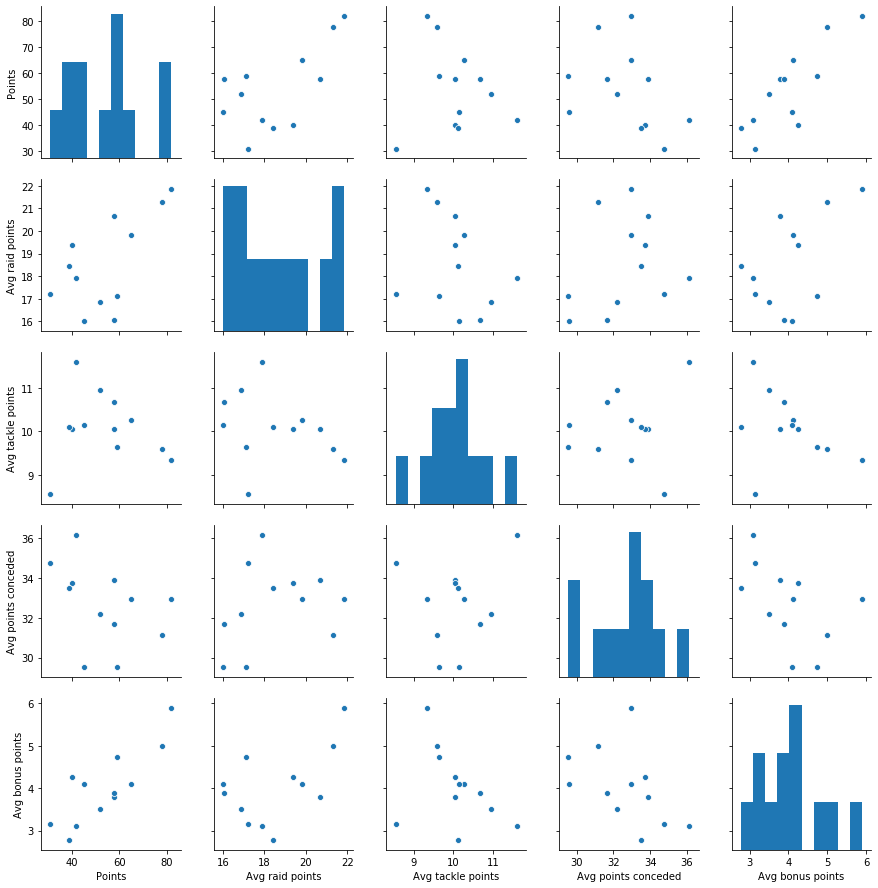

In [638]:
sns.pairplot(result_df[['Points','Avg raid points','Avg tackle points','Avg points conceded','Avg bonus points'
        ]])

In [578]:
hack_sm=sm.add_constant(hack_X)

In [579]:
#using Linear regression to predict
hack_model=sm.OLS(hack_y,hack_sm).fit()

In [580]:
hack_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     7.898
Date:                Wed, 02 Oct 2019   Prob (F-statistic):            0.00982
Time:                        21:03:02   Log-Likelihood:                -39.318
No. Observations:                  12   AIC:                             88.64
Df Residuals:                       7   BIC:                             91.06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -27.8606     70.247     -0.397      0.703    -193.968     138.247
Avg raid points         3.9744      2.061      1.929      0.095      -0.899       8.848
Avg tackle points       5.3326      3.504      1.522      0.172      -2.953      13.618
Avg points conceded    -2.4860      2.012     -1.236      0.256      -7.243       2.271
Avg bonus points        8.8601      5.183      1.709      0.131      -3.397      21.117
==============================================================================
Omnibus:                        8.393   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                4.036
Skew:                          -1.251   Prob(JB):                        0.133
Kurtosis:                       4.347   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [581]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X = hack_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,841.13
4,Avg bonus points,3.27
1,Avg raid points,2.73
3,Avg points conceded,2.47
2,Avg tackle points,1.18


In [582]:
hack_model.params

const                 -27.860551
Avg raid points         3.974428
Avg tackle points       5.332597
Avg points conceded    -2.486002
Avg bonus points        8.860147
dtype: float64

In [583]:
hack_lis=['Avg raid points','Avg tackle points','Avg points conceded','Avg bonus points']

In [584]:
def get_data_from_table_hack(index):
    df=pd.DataFrame(result_df.set_index('Name').loc[index][hack_lis]).T
    df['const']=1
    df=df[list(df.columns.values[-1:])+list(df.columns.values[:-1])]
    return df

In [585]:
previous_result_hack=previous_result[previous_result['Winner']!="Match to be played"]

In [586]:
def get_from_previousresult_hack(team1,team2):
    a=previous_result_hack
    previous_win_data=a[((a['team']==team1)&(a['opponent']==team2))|((a['team']==team2)&(a['opponent']==team1))]
    if(team1==previous_win_data['Winner'].values[0]):
        points_dif=previous_win_data['PointsDiff'].values[0]
        return (int(points_dif),-int(points_dif))
    elif(team2==previous_win_data['Winner'].values[0]):
        points_dif=previous_win_data['PointsDiff'].values[0]
        return (-int(points_dif),int(points_dif))
    else:
        return (1,1)

In [587]:
matches_to_be_played_with_TBC=previous_result[previous_result['Winner']=="Match to be played"]

In [588]:
matches_to_be_played=matches_to_be_played_with_TBC[:-5]

In [589]:
future_matches=list(zip(matches_to_be_played['team'],matches_to_be_played['opponent']))

In [590]:
predicted_results=pd.DataFrame(future_matches,columns=["Team1","Team2"])

In [591]:
def win_predictor(match):
    team1,team2=match
    pts1=get_data_from_table_hack(team1)
    pts2=get_data_from_table_hack(team2)
    wgt1=hack_model.predict(pts1)
    wgt1=wgt1.values[0]
    wgt2=hack_model.predict(pts2)
    wgt2=wgt2.values[0]
    pwgt1,pwgt2=get_from_previousresult_hack(team1,team2)
    if (wgt1+pwgt1)>(wgt2+pwgt2):
        return team1,round((wgt1+pwgt1)-(wgt2+pwgt2),2)
    elif (wgt2+pwgt2)>(wgt1+pwgt1):
        return team2,round((wgt2+pwgt2)-(wgt1+pwgt1),2)
    else:
        return ("tie",0)

In [592]:
from random import randrange,randint,random

In [593]:
#adding advantage of toss in luck
def win_predictor_luck1(match):
    team1,team2=match
    weight1=1
    weight2=1
    toss=random()
    if toss>0.5:
        weight1=weight1+(random()/2)
    elif toss==0.5:
        weight1=1
        weight2=1
    else:
        weight2=weight2+(random()/2)
    pts1=get_data_from_table_hack(team1)
    pts2=get_data_from_table_hack(team2)
    wgt1=hack_model.predict(pts1)
    wgt1=wgt1.values[0]*weight1
    wgt2=hack_model.predict(pts2)
    wgt2=wgt2.values[0]*weight2
    pwgt1,pwgt2=get_from_previousresult_hack(team1,team2)
    if (wgt1+pwgt1)>(wgt2+pwgt2):
        return team1,round((wgt1+pwgt1)-(wgt2+pwgt2),2)
    elif (wgt2+pwgt2)>(wgt1+pwgt1):
        return team2,round((wgt2+pwgt2)-(wgt1+pwgt1),2)
    else:
        return ("tie",0)

In [594]:
def win_predictor_luck2(match):
    team1,team2=match
    weight1=1
    weight2=1
    toss=random()
    if toss>0.5:
        weight1=weight1+(random()/2)
    elif toss==0.5:
        weight1=1
        weight2=1
    else:
        weight2=weight2+(random()/2)
    pts1=get_data_from_table_hack(team1)
    pts2=get_data_from_table_hack(team2)
    wgt1=hack_model.predict(pts1)
    wgt1=wgt1.values[0]
    wgt2=hack_model.predict(pts2)
    wgt2=wgt2.values[0]
    pwgt1,pwgt2=get_from_previousresult_hack(team1,team2)
    pwgt1=pwgt1*weight1
    pwgt2=pwgt2*weight2
    if (wgt1+pwgt1)>(wgt2+pwgt2):
        return team1,round((wgt1+pwgt1)-(wgt2+pwgt2),2)
    elif (wgt2+pwgt2)>(wgt1+pwgt1):
        return team2,round((wgt2+pwgt2)-(wgt1+pwgt1),2)
    else:
        return ("tie",0)

In [595]:
#league points
def league_points(score):
    if score>=15:
        return 5
    else:
        return 3      

In [596]:
winner=[]
winnerluck1=[]
winnerluck2=[]
for match in future_matches:
    winner.append(win_predictor(match))
    winnerluck1.append(win_predictor_luck1(match))
    winnerluck2.append(win_predictor_luck2(match))

In [597]:
predicted_wins=pd.DataFrame(winner,columns=["Winner","ScoreDiff"])
predicted_wins['Win']=predicted_wins['ScoreDiff'].apply(league_points)
predicted_wins1=pd.DataFrame(winnerluck1,columns=["Winnerluck1","ScoreDiff1"])
predicted_wins1['Winluck1']=predicted_wins1['ScoreDiff1'].apply(league_points)
predicted_wins2=pd.DataFrame(winnerluck2,columns=["Winnerluck2","ScoreDiff2"])
predicted_wins2['Winluck2']=predicted_wins2['ScoreDiff2'].apply(league_points)

In [598]:
predicted_wins=pd.concat([predicted_results,predicted_wins,predicted_wins1,predicted_wins2],axis=1)

In [599]:
predicted_wins

,Team1,Team2,Winner,ScoreDiff,Win,Winnerluck1,ScoreDiff1,Winluck1,Winnerluck2,ScoreDiff2,Winluck2
0,U Mumba,Patna Pirates,U Mumba,11.50,3,U Mumba,12.23,3,U Mumba,12.02,3
1,Haryana Steelers,Bengaluru Bulls,Haryana Steelers,8.95,3,Haryana Steelers,8.47,3,Haryana Steelers,9.10,3
2,Telugu Titans,Puneri Paltan,Puneri Paltan,16.05,5,Telugu Titans,1.48,3,Puneri Paltan,18.73,5
3,Jaipur Pink Panthers,Bengaluru Bulls,Bengaluru Bulls,30.79,5,Bengaluru Bulls,49.43,5,Bengaluru Bulls,34.14,5
4,Haryana Steelers,Telugu Titans,Telugu Titans,2.48,3,Telugu Titans,1.98,3,Telugu Titans,7.42,3
5,U.P. Yoddha,Dabang Delhi K.C.,Dabang Delhi K.C.,48.60,5,Dabang Delhi K.C.,86.84,5,Dabang Delhi K.C.,50.09,5
6,Gujarat Fortunegiants,Patna Pirates,Gujarat Fortunegiants,2.14,3,Gujarat Fortunegiants,22.23,5,Gujarat Fortunegiants,2.24,3
7,Bengal Warriors,Patna Pirates,Bengal Warriors,36.27,5,Bengal Warriors,39.26,5,Bengal Warriors,38.66,5
8,U.P. Yoddha,Puneri Paltan,U.P. Yoddha,15.86,5,U.P. Yoddha,28.47,5,U.P. Yoddha,17.78,5
9,Telugu Titans,Gujarat Fortunegiants,Gujarat Fortunegiants,0.03,3,Telugu Titans,19.55,5,Telugu Titans,2.50,3


- The team that wins the match will be awarded 5 league points and the loser will get 0 points,
if the margin of victory is more than 7 points.
- In case of a tie, both the sides will score 3 league points each.

In [600]:
def predicted_points(team):
    try:
        future_pts=predicted_wins.groupby('Winner').sum()['Win'][team]
    except:
        future_pts=0
    current_pts=points_df[points_df['team']==team]['pts']
    return int(future_pts)+int(current_pts)

In [601]:
def predicted_points_luck1(team):
    try:
        future_pts=predicted_wins.groupby('Winnerluck1').sum()['Winluck1'][team]
    except:
        future_pts=0
    current_pts=points_df[points_df['team']==team]['pts']
    return int(future_pts)+int(current_pts)

In [602]:
def predicted_points_luck2(team):
    try:
        future_pts=predicted_wins.groupby('Winnerluck2').sum()['Winluck2'][team]
    except:
        future_pts=0
    current_pts=points_df[points_df['team']==team]['pts']
    return int(future_pts)+int(current_pts)

In [603]:
points_df['predictedpts']=points_df['team'].apply(predicted_points)

In [604]:
points_df['predictedptsluck1']=points_df['team'].apply(predicted_points_luck1)

In [605]:
points_df['predictedptsluck2']=points_df['team'].apply(predicted_points_luck2)

In [606]:
points_df['Avgpts']=round((points_df['predictedpts']+points_df['predictedptsluck1']+points_df['predictedptsluck2'])/3,0)

## 1.League table topper

In [607]:
points_df

,rank,team,p,w,l,t,score diff.,pts,predictedpts,predictedptsluck1,predictedptsluck2,Avgpts
0,1,Dabang Delhi K.C.,20,15,3,2,83,82,92,92,92,92.0
1,2,Bengal Warriors,20,13,4,3,95,78,88,88,88,88.0
2,3,Haryana Steelers,19,12,6,1,24,65,71,68,71,70.0
3,4,U Mumba,19,10,8,1,37,59,62,65,62,63.0
4,5,Bengaluru Bulls,19,10,8,1,12,58,66,68,66,67.0
5,6,U.P. Yoddha,18,10,6,2,-19,58,66,68,66,67.0
6,7,Jaipur Pink Panthers,20,8,10,2,-18,52,57,57,57,57.0
7,8,Gujarat Fortunegiants,20,6,12,2,14,45,51,50,48,50.0
8,9,Puneri Paltan,20,6,11,3,-71,42,47,42,47,45.0
9,10,Patna Pirates,19,6,12,1,-1,40,40,40,40,40.0


## - Recommend teams for top league table

- 1.Dabang Delhi 
- 2.Bengal Warriors
- 3.Haryana Steelers

## 2.Tournment winner

- Rank3 Vs Rank 6  --- eliminator1
- Rank4 Vs Rank 5  --- eliminator2
- Rank1 vs eliminator1 --semi1
- Rank2 vs eliminator2 --semi2
- semi1 vs semi2-- final

### 'Haryana Steelers' vs 'U.P. Yoddha'

In [608]:
win_predictor(('Haryana Steelers','U.P. Yoddha'))

('Haryana Steelers', 17.6)

In [609]:
win_predictor_luck1(('Haryana Steelers','U.P. Yoddha'))

('Haryana Steelers', 21.66)

In [610]:
win_predictor_luck2(('Haryana Steelers','U.P. Yoddha'))

('Haryana Steelers', 18.02)

- Rank3 Vs Rank 6  --- eliminator1 -- Haryana
- Rank4 Vs Rank 5  --- eliminator2  --Benguluru 
- Rank1 vs eliminator1 --semi1
- Rank2 vs eliminator2 --semi2
- semi1 vs semi2-- final

U Mumba vs Bengaluru Bulls

In [611]:
team=('U Mumba','Bengaluru Bulls')

In [612]:
win_predictor(team)

('Bengaluru Bulls', 5.17)

In [613]:
win_predictor_luck1(team)

('Bengaluru Bulls', 1.27)

In [614]:
win_predictor_luck2(team)

('Bengaluru Bulls', 6.82)

Semi1

In [615]:
team=('Dabang Delhi K.C.','Haryana Steelers')

In [616]:
win_predictor(team)

('Dabang Delhi K.C.', 59.0)

In [617]:
win_predictor_luck1(team)

('Dabang Delhi K.C.', 53.58)

In [618]:
win_predictor_luck2(team)

('Dabang Delhi K.C.', 59.18)

semi2

In [208]:
team=('Bengal Warriors','Bengaluru Bulls')

In [209]:
win_predictor(team)

('Bengal Warriors', 15.6)

In [210]:
win_predictor_luck1(team)

('Bengaluru Bulls', 12.74)

In [211]:
win_predictor_luck2(team)

('Bengal Warriors', 15.12)

 Final

In [212]:
team=('Dabang Delhi K.C.','Bengal Warriors')

In [213]:
win_predictor(team)

('Dabang Delhi K.C.', 4.35)

In [214]:
win_predictor_luck1(team)

('Dabang Delhi K.C.', 35.11)

In [215]:
win_predictor_luck2(team)

('Dabang Delhi K.C.', 4.54)

### Recommendations of Tournment winner

- Dabang Delhi     -- 40%
- Bengal Warriors  -- 25%
- Benguluru Bulls  -- 15%
- Haryana Steelers -- 10%
- U Mumbai         -- 10%

## Matches 

- Rank3 Vs Rank 6  --- eliminator1 -- Haryana
- Rank4 Vs Rank 5  --- eliminator2  --Benguluru 
- Rank1 vs eliminator1 --semi1 -- Delhi
- Rank2 vs eliminator2 --semi2 -- Bengal
- semi1 vs semi2-- final -- Delhi

In [631]:
predicted_points_df=points_df[['team','p']]

In [632]:
def predictmatches(team):
    if "Haryana" in team:
        return 24
    elif "U.P" in team:
        return 23
    elif "Delhi" in team:
        return 24
    elif "Bengal" in team:
        return 24
    elif "Benguluru" in team:
        return 24
    elif "U Mumba" in team:
        return 23
    else:
        return 22

In [633]:
result_df['PredMtsPlyd']=predicted_points_df['team'].apply(predictmatches)

In [634]:
result_df.head()

,Name,Matches played,Total points scored,Total points conceded,Avg points scored,Successful raids,Raid points,Avg raid points,Successful tackles,Tackle points,...,All-outs inflicted,All-outs conceded,Points,Avg sucessful tackles,Avg sucessful raids,Avg points conceded,Avg allouts inflicted,Avg allouts conceded,Avg bonus points,PredMtsPlyd
0,Dabang Delhi K.C.,20,742,659,37.10,361,437,21.85,181,187,...,34,18,82,9.05,18.05,32.95,1.70,0.90,5.90,24
1,Bengal Warriors,20,718,623,35.90,340,426,21.30,182,192,...,34,17,78,9.10,17.00,31.15,1.70,0.85,5.00,24
4,Haryana Steelers,19,650,626,34.21,290,377,19.84,181,195,...,27,21,65,9.53,15.26,32.95,1.42,1.11,4.11,24
8,U Mumba,19,598,561,31.47,258,325,17.11,168,183,...,26,21,59,8.84,13.58,29.53,1.37,1.11,4.74,22
2,Bengaluru Bulls,19,656,644,34.53,309,393,20.68,168,191,...,21,24,58,8.84,16.26,33.89,1.11,1.26,3.79,24


## 3.Best team in Raids

In [518]:
raids_df=result_df[['Name','Matches played','Raid points','Avg raid points','PredMtsPlyd']]

In [519]:
def get_data_for_raids(index):
    avgraidpts=raids_df.set_index('Name').loc[index]['Avg raid points']
    premtsplyd=raids_df.set_index('Name').loc[index]['PredMtsPlyd']
    return index,round(float(avgraidpts)*int(premtsplyd),0)

In [520]:
raidpts=[]
for i in raids_df['Name'].values:
    raidpts.append(get_data_for_raids(i))

In [521]:
raids=pd.DataFrame(raidpts,columns=['Name','Predicted raid points'])

In [522]:
raids_pred=pd.merge(raids_df,raids,on='Name')

In [523]:
raids_pred.sort_values(by='Predicted raid points',ascending=False,inplace=True)

In [524]:
raids_pred

,Name,Matches played,Raid points,Avg raid points,PredMtsPlyd,Predicted raid points
0,Dabang Delhi K.C.,20,437,21.85,24,524.0
1,Bengal Warriors,20,426,21.30,24,511.0
4,Bengaluru Bulls,19,393,20.68,24,496.0
2,Haryana Steelers,19,377,19.84,24,476.0
9,Patna Pirates,19,368,19.37,23,446.0
8,Puneri Paltan,20,358,17.90,23,412.0
10,Telugu Titans,18,332,18.44,22,406.0
11,Tamil Thalaivas,20,344,17.20,22,378.0
3,U Mumba,19,325,17.11,22,376.0
6,Jaipur Pink Panthers,20,337,16.85,22,371.0


## Recommened Team Name for best Raids 

- 1.Dabang Delhi K.C.
- 2.Bengal Warriors
- 3.Bengaluru Bulls

## 4.Best team in Tackles

In [525]:
tackles_df=result_df[['Name','Matches played','Tackle points','Avg tackle points','PredMtsPlyd']]

In [526]:
def get_data_for_tackles(index):
    avgtacklepts=tackles_df.set_index('Name').loc[index]['Avg tackle points']
    premtsplyd=tackles_df.set_index('Name').loc[index]['PredMtsPlyd']
    return index,round(float(avgtacklepts)*int(premtsplyd),0)

In [527]:
tacklepts=[]
for i in tackles_df['Name'].values:
    tacklepts.append(get_data_for_tackles(i))

In [528]:
tackles=pd.DataFrame(tacklepts,columns=['Name','Predicted tackle points'])

In [529]:
tackle_pred=pd.merge(tackles_df,tackles,on='Name')

In [530]:
tackle_pred.sort_values(by='Predicted tackle points',ascending=False,inplace=True)

In [531]:
tackle_pred

,Name,Matches played,Tackle points,Avg tackle points,PredMtsPlyd,Predicted tackle points
8,Puneri Paltan,20,232,11.60,23,267.0
2,Haryana Steelers,19,195,10.26,24,246.0
4,Bengaluru Bulls,19,191,10.05,24,241.0
6,Jaipur Pink Panthers,20,219,10.95,22,241.0
5,U.P. Yoddha,18,192,10.67,22,235.0
9,Patna Pirates,19,191,10.05,23,231.0
1,Bengal Warriors,20,192,9.60,24,230.0
0,Dabang Delhi K.C.,20,187,9.35,24,224.0
7,Gujarat Fortunegiants,20,203,10.15,22,223.0
10,Telugu Titans,18,182,10.11,22,222.0


## Recommened Team Name for best Tackles 

- 1.Puneri Paltans
- 2.Haryana Steelers
- 3.Bengaluru Bulls

## 5.Superperformace Total

In [537]:
superperformance_df=result_df.copy()

In [538]:
superperformance_df['Avg Super raid']=round(superperformance_df['Super raid']/superperformance_df['Matches played'],2)
superperformance_df['Avg Super tackles']=round(superperformance_df['Super tackles']/superperformance_df['Matches played'],2)

In [539]:
superperformance_df['Avg S.P.T']=superperformance_df['Avg Super raid']+superperformance_df['Avg Super tackles']+superperformance_df['Avg allouts inflicted']-superperformance_df['Avg allouts conceded']

In [540]:
superperformance_df.head()

,Name,Matches played,Total points scored,Total points conceded,Avg points scored,Successful raids,Raid points,Avg raid points,Successful tackles,Tackle points,...,Avg sucessful tackles,Avg sucessful raids,Avg points conceded,Avg allouts inflicted,Avg allouts conceded,Avg bonus points,PredMtsPlyd,Avg Super raid,Avg Super tackles,Avg S.P.T
0,Dabang Delhi K.C.,20,742,659,37.10,361,437,21.85,181,187,...,9.05,18.05,32.95,1.70,0.90,5.90,24,0.40,0.40,1.60
1,Bengal Warriors,20,718,623,35.90,340,426,21.30,182,192,...,9.10,17.00,31.15,1.70,0.85,5.00,24,0.75,0.60,2.20
4,Haryana Steelers,19,650,626,34.21,290,377,19.84,181,195,...,9.53,15.26,32.95,1.42,1.11,4.11,24,0.74,0.74,1.79
8,U Mumba,19,598,561,31.47,258,325,17.11,168,183,...,8.84,13.58,29.53,1.37,1.11,4.74,22,0.37,0.95,1.58
2,Bengaluru Bulls,19,656,644,34.53,309,393,20.68,168,191,...,8.84,16.26,33.89,1.11,1.26,3.79,24,0.42,1.32,1.59


In [ ]:
#above model is not required 

In [542]:
def get_data_for_spt(index):
    avgspt=superperformance_df.set_index('Name').loc[index]['Avg S.P.T']
    premtsplyd=superperformance_df.set_index('Name').loc[index]['PredMtsPlyd']
    return index,float(avgspt)*int(premtsplyd)

In [543]:
predicted_SPT_df=superperformance_df[['Name','Matches played','Avg S.P.T','Avg Super raid','Avg Super tackles',
                                      'Avg allouts inflicted','Avg allouts conceded']]

In [544]:
spt=[]
for i in superperformance_df['Name'].values:
    spt.append(get_data_for_spt(i))

In [545]:
SPT=pd.DataFrame(spt,columns=['Name','S.P.T'])

In [546]:
SPT_pred=pd.merge(predicted_SPT_df,SPT,on='Name')

In [547]:
SPT_pred.sort_values(by='S.P.T',ascending=False)

,Name,Matches played,Avg S.P.T,Avg Super raid,Avg Super tackles,Avg allouts inflicted,Avg allouts conceded,S.P.T
1,Bengal Warriors,20,2.20,0.75,0.60,1.70,0.85,52.80
9,Patna Pirates,19,2.15,0.68,1.21,1.47,1.21,49.45
2,Haryana Steelers,19,1.79,0.74,0.74,1.42,1.11,42.96
6,Jaipur Pink Panthers,20,1.75,0.35,1.60,0.95,1.15,38.50
0,Dabang Delhi K.C.,20,1.60,0.40,0.40,1.70,0.90,38.40
4,Bengaluru Bulls,19,1.59,0.42,1.32,1.11,1.26,38.16
3,U Mumba,19,1.58,0.37,0.95,1.37,1.11,34.76
10,Telugu Titans,18,1.17,0.50,1.17,0.72,1.22,25.74
5,U.P. Yoddha,18,1.12,0.28,0.89,1.17,1.22,24.64
7,Gujarat Fortunegiants,20,1.05,0.25,0.85,1.05,1.10,23.10


### Recommendation for superperformance total Team

  - 1. Bengal Warriors
  - 2. Patna Pirates
  - 3. Haryana Steelers

 ##  6.Player with highest succesfull raid percentage

In [484]:
def Successful_Raid_Percentage(table_columns,headings):
    dis={}
    time.sleep(1)
    for col in range(len(table_columns)):
        data=[]
        data=[table.find_all('div',{'class':table_columns[col]})[row].text.strip() for row in range(1,6)]
        dis[headings[col]]=data
    page_df=pd.DataFrame(dis)
    return page_df

In [481]:
url='https://www.sportskeeda.com/go/pro-kabaddi/stats'
table_columns=['index','name','team','points']
headings=['Index','Name','Team','Points']

In [482]:
driver=invokebrowser(url)
driver.find_element_by_xpath('/html/body/div[7]/div[1]/div/div[3]/div[6]/a').click()
time.sleep(2)
soup=soup_website(driver)
table=soup.find('div',{'class':'stats-div'})
Successful_Raid_df=Successful_Raid_Percentage(table_columns,headings)
closedriver(driver)

In [483]:
Successful_Raid_df.head()

,Index,Name,Team,Points
0,1,Saurabh Nandal,Bengaluru Bulls,100
1,2,Chand Singh,Haryana Steelers,100
2,3,Ankush,U.P. Yoddha,66.67
3,4,Pawan Kumar Sehrawat,Bengaluru Bulls,54.94
4,5,Naveen Kumar,Dabang Delhi K.C.,53.89


## Recommendations of player for highest raid percentage
##### Note there is no minimum matches critieria mentioned 

- Saurabh Nandal
- Chand Singh
- Ankush
- Pawan Kumar Sehrawat
- Naveen Kumar

 ##  7.Player with highest succesfull tackle percentage

In [485]:
def Successful_Tackle_Percentage(table_columns,headings):
    dis={}
    time.sleep(1)
    for col in range(len(table_columns)):
        data=[]
        data=[table.find_all('div',{'class':table_columns[col]})[row].text.strip() for row in range(1,6)]
        dis[headings[col]]=data
    page_df=pd.DataFrame(dis)
    return page_df

In [486]:
# sometimes website asks for robot check so code might break here please rerun after autheticating.
url='https://www.sportskeeda.com/go/pro-kabaddi/stats'
driver=invokebrowser(url)
driver.find_element_by_xpath('/html/body/div[7]/div[1]/div/div[3]/div[7]/a').click()
time.sleep(2)
soup=soup_website(driver)
table=soup.find('div',{'class':'content-holder'})
Successful_tackle_df=Successful_Tackle_Percentage(table_columns,headings)
closedriver(driver)

In [487]:
Successful_tackle_df

,Index,Name,Team,Points
0,1,Ravindra Ramesh Kumawat,Bengal Warriors,100
1,2,Lalit Chaudhary,Gujarat Fortune Giants,100
2,3,Ankush,U.P. Yoddha,100
3,4,Sonu,Gujarat Fortune Giants,75
4,5,Gurdeep,U.P. Yoddha,66.67


### Recommendations of Players for Success Tackle percentage

- Ravindra Ramesh Kumawat
- Lalit Chaudhary
- Ankush
- Sonu
- Gurdeep